# Imports & data loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
df = pd.read_excel("realized.xlsx", engine='openpyxl')
print(f"{len(df)} observations.")
df.head()

39449 observations.


,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor
0,2021-01-01 06:35:00,IA,874,DEN,73W,J,US,142,0.408451
1,2021-01-01 10:35:00,JZ,818,YHM,AT7,J,CA,74,0.189189
2,2021-01-01 12:05:00,IA,876,DEN,73W,J,US,142,0.570423
3,2021-01-01 13:20:00,CN,514,EST,AT7,J,US,72,0.333333
4,2021-01-01 14:20:00,LJ,3140,DEN,32A,J,US,186,0.204301


Create additional features based on ScheduleTime

In [3]:
df['Minute'] = df['ScheduleTime'].dt.minute
df['Hour'] = df['ScheduleTime'].dt.hour
df['Day'] = df['ScheduleTime'].dt.day
df['Week'] = df['ScheduleTime'].dt.isocalendar().week
df['Month'] = df['ScheduleTime'].dt.month

In [4]:
df.head()

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor,Minute,Hour,Day,Week,Month
0,2021-01-01 06:35:00,IA,874,DEN,73W,J,US,142,0.408451,35,6,1,53,1
1,2021-01-01 10:35:00,JZ,818,YHM,AT7,J,CA,74,0.189189,35,10,1,53,1
2,2021-01-01 12:05:00,IA,876,DEN,73W,J,US,142,0.570423,5,12,1,53,1
3,2021-01-01 13:20:00,CN,514,EST,AT7,J,US,72,0.333333,20,13,1,53,1
4,2021-01-01 14:20:00,LJ,3140,DEN,32A,J,US,186,0.204301,20,14,1,53,1


# Analysis
## Correlation coefficients
We'll start off by looking at the Pearson correlation coefficinet for some of the categorical features.

In [5]:
from sklearn.feature_selection import r_regression

fig, axs = plt.subplots(4,2, figsize=(20,10))
for feature, ax in zip(["Airline", "Destination", "AircraftType", "FlightType", "Sector", "SeatCapacity", "Week", "Month"], axs.flatten()):
    col_names = pd.get_dummies(df[feature]).columns.astype(str)
    coeffs = r_regression(pd.get_dummies(df[feature]), df['LoadFactor'])
    ax.set_title(feature)
    ax.plot(col_names, coeffs)
plt.tight_layout()
plt.show()

ImportError: cannot import name 'r_regression'

There seems to be one airline that is heavily negatively correlated to the `LoadFactor` compared to the other airlines.

In [124]:
pd.get_dummies(df['Airline']).columns[r_regression(pd.get_dummies(df["Airline"]), df['LoadFactor']).argmin()]

'DO'

In [125]:
df['Airline'].value_counts()[:10]

DO    9808
CL    4205
LJ    3237
CN    2418
ZY    1824
VW    1675
IA    1315
LZ    1150
UK    1046
SV    1025
Name: Airline, dtype: int64

It appears that this airline is also the largest.

It also seems like there is a lot of variability in `Weeks` throughout the series which would indicate that it's a good predictor (?)

## Time-dependent features
Now looking at the time-dependent features.

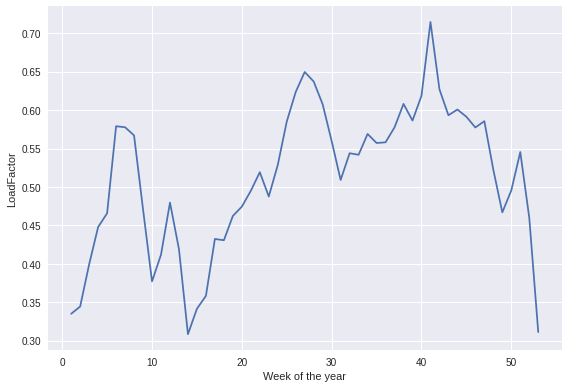

In [11]:
plt.plot(df.groupby("Week")["LoadFactor"].mean())
plt.ylabel("LoadFactor")
plt.xlabel("Week of the year")
plt.tight_layout()
plt.savefig("seasonality.png")

/usr/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


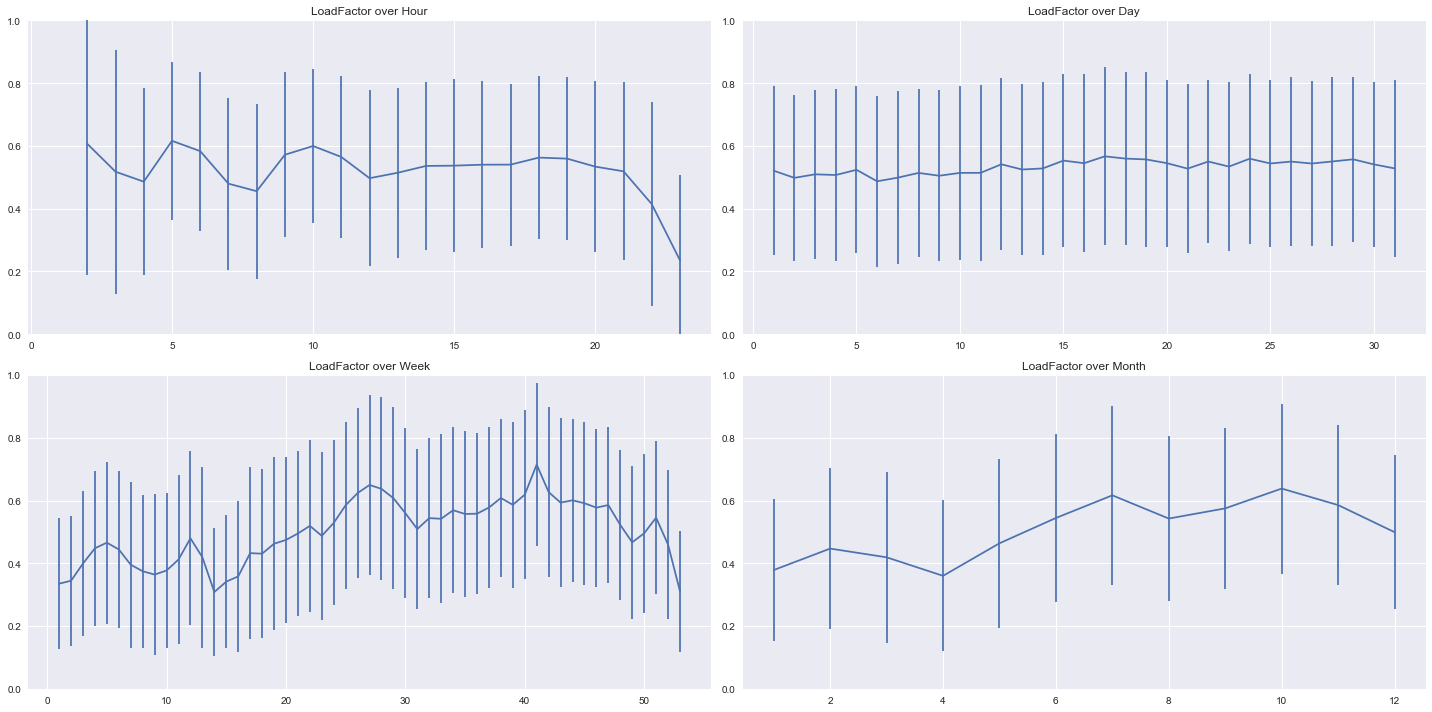

In [62]:
fig, axs = plt.subplots(2,2, figsize=(20,10))
for time_feature, ax in zip(['Hour', 'Day', 'Week', 'Month'], axs.flatten()):
    x_axis = range(1,df[time_feature].nunique()+1)
    ax.set_ylim(0,1)
    ax.set_title(f"LoadFactor over {time_feature}")
    ax.errorbar(x_axis, 
                [df[df[time_feature] == x]["LoadFactor"].mean() for x in x_axis],
                yerr=[df[df[time_feature] == x]["LoadFactor"].std() for x in x_axis])
plt.tight_layout()
plt.show()

The most important one seems to be the week of the year.

Perhaps not all Airlines' LoadFactor follow the same distribution. A larger airline may have different standards or can afford lower LoadFactors.

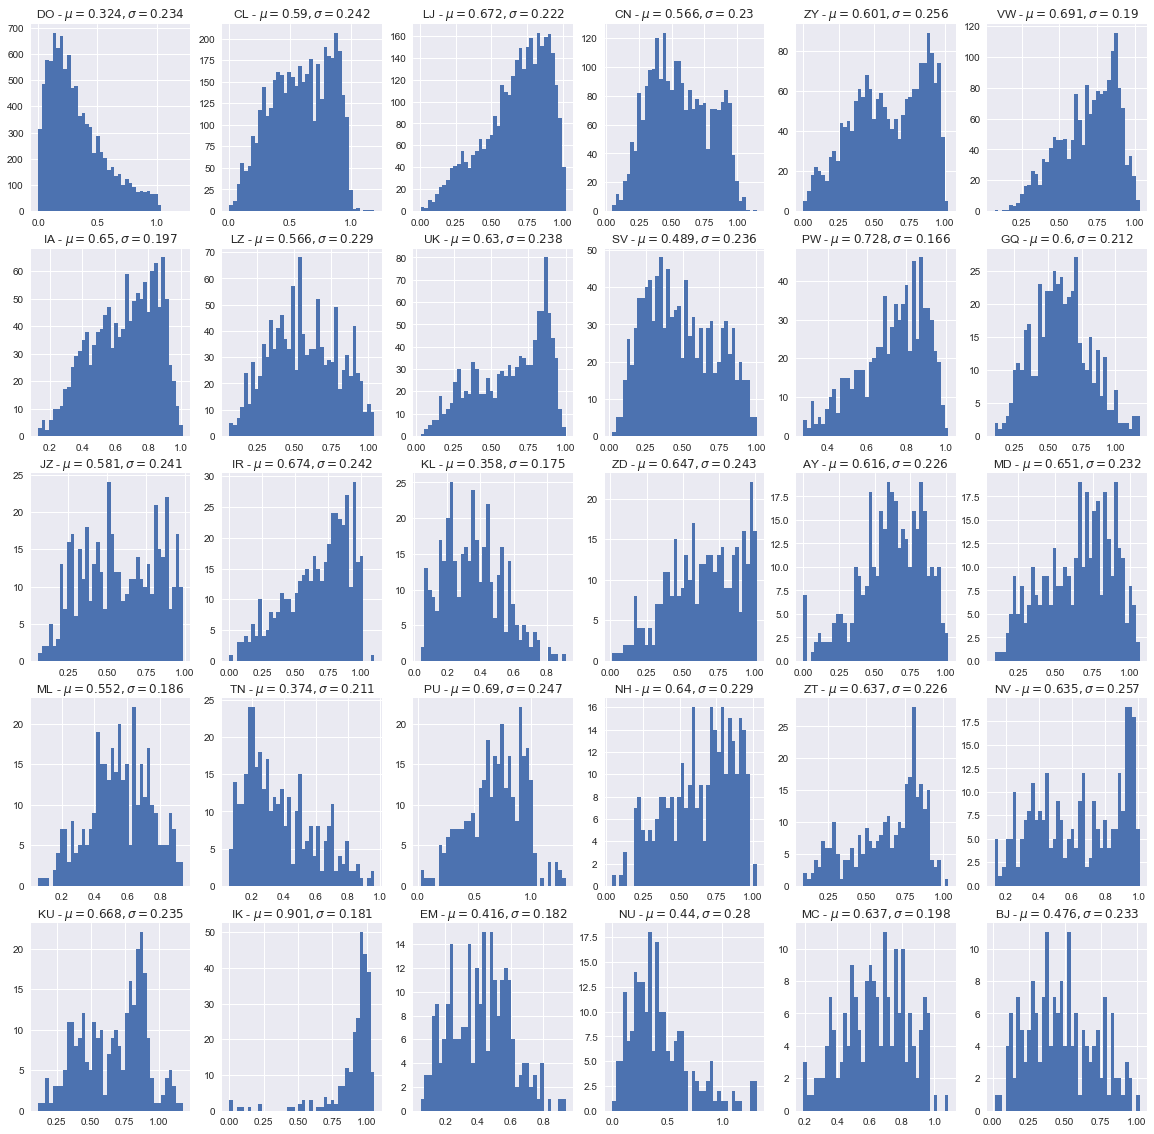

In [122]:
fig, axs = plt.subplots(5,6, figsize=(20,20))

for i, (airline, ax) in enumerate(zip(df['Airline'].value_counts().index[:30], axs.flatten())):
    loadfactors = df[df['Airline'] == airline]['LoadFactor']
    ax.hist(loadfactors, bins=40)
    ax.set_title(f"{airline} - $\mu={round(loadfactors.mean(),3)}, \sigma={round(loadfactors.std(), 3)}$")
plt.show()

The sectors seems to be highly dominated by CA and US. Let's group the rest in "Others" which will come in handy if we want to do one-hot-encoding.

In [123]:
df['Sector'].value_counts()

CA    17906
US    17575
IS      450
QA      345
AE      165
DK       95
SG       95
EG       88
CN       44
IQ        3
NL        1
MX        1
Name: Sector, dtype: int64

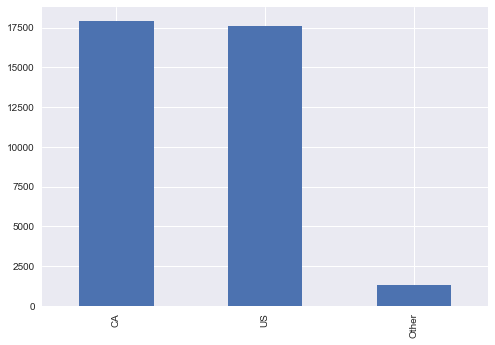

In [124]:
df['Sector'] = df['Sector'].apply(lambda x: x if x in ['CA', 'US'] else 'Other')
df['Sector'].value_counts().plot(kind='bar')
plt.show()

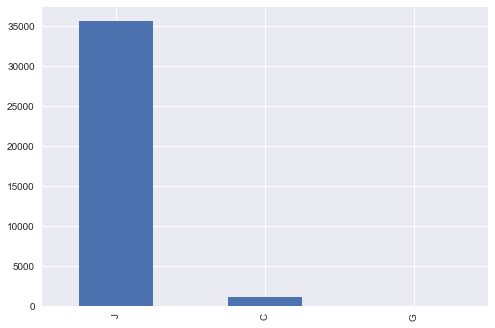

In [88]:
df['FlightType'].value_counts().plot(kind='bar')
plt.show()

In [129]:
df['AircraftType'].value_counts()[:10]

73H    8317
32N    5707
CR9    3367
AT7    3248
319    2940
320    2834
32A    1815
E90    1213
32Q     711
359     627
Name: AircraftType, dtype: int64

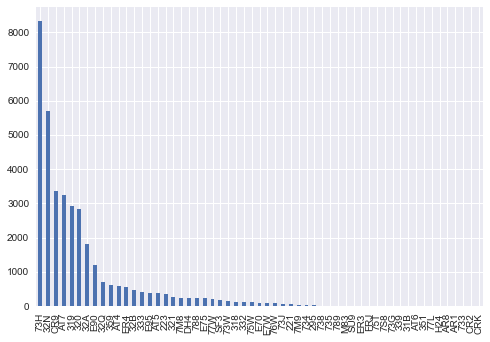

In [89]:
df['AircraftType'].value_counts().plot(kind='bar')
plt.show()